In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import cPickle as pickle
import fastparquet

weather data from https://www1.ncdc.noaa.gov/pub/data/ghcn/daily

# keep what is needed 

In [3]:
def reverse_map(d):
    return {v:k for k,v in d.items()}
def encoding_dict(names):
    names=sorted(names)
    a=dict(enumerate(names))
    b=reverse_map(a)
    return b,a

In [4]:
visits=pd.read_csv("../input/air_visit_data.csv",parse_dates=['visit_date'])
print visits.shape

(252108, 3)


In [5]:
dates=pd.read_csv("../input/date_info.csv",parse_dates=['calendar_date'])
print dates.shape

(517, 3)


In [6]:
stores=sorted(set(visits['air_store_id']))
len(stores)

829

In [7]:
date_list=pd.date_range(pd.to_datetime("2016-01-01"),pd.to_datetime("2017-05-31"))
len(date_list)

517

In [8]:
reserves=pd.read_csv("../input/new_reserves.csv",parse_dates=['visit_datetime','reserve_datetime'])
reserves.shape,reserves['reserve_datetime'].max()

((120561, 6), Timestamp('2017-04-22 00:00:00'))

In [9]:
storeinfo=pd.read_csv("../input/newstoreinfo.csv")
storeinfo.shape

(892, 10)

# put train test together

In [10]:
sample=pd.read_csv("../input/sample_submission.csv")
sample['air_store_id']=sample['id'].map(lambda u: "_".join(u.split("_")[:2]))
sample['visit_date']=sample['id'].map(lambda u: pd.to_datetime(u.split("_")[2],format="%Y-%m-%d"))

In [11]:
sample=sample[visits.columns]
sample['visitors']=np.nan

In [12]:
sample['visit_date'].min()

Timestamp('2017-04-23 00:00:00')

In [13]:
train_test=pd.concat([visits,sample])

In [14]:
train_test['visitors']=np.log1p(train_test['visitors'])

In [15]:
train_test.head()

air_store_id visit_date  visitors
0  air_ba937bf13d40fb24 2016-01-13  3.258097
1  air_ba937bf13d40fb24 2016-01-14  3.496508
2  air_ba937bf13d40fb24 2016-01-15  3.401197
3  air_ba937bf13d40fb24 2016-01-16  3.135494
4  air_ba937bf13d40fb24 2016-01-18  1.945910

In [16]:
train_test.tail()

air_store_id visit_date  visitors
32014  air_fff68b929994bfbd 2017-05-27       NaN
32015  air_fff68b929994bfbd 2017-05-28       NaN
32016  air_fff68b929994bfbd 2017-05-29       NaN
32017  air_fff68b929994bfbd 2017-05-30       NaN
32018  air_fff68b929994bfbd 2017-05-31       NaN

# make reservers

In [17]:
np.sum([u<pd.to_datetime('2017-04-23') for u in date_list]), \
np.sum([u>=pd.to_datetime('2017-04-23') for u in date_list])

(478, 39)

In [18]:
reserves=pd.merge(reserves,train_test,left_on=['store_id','visit_datetime'], right_on=['air_store_id','visit_date'],how='left')

In [19]:
#reserves=reserves[~reserves['air_store_id'].isnull()]

In [20]:
#reserves=reserves[~reserves['visitors'].isnull()]

In [21]:
reserves['y']=np.expm1(reserves['visitors'])

In [22]:
reserves=reserves[reserves.gap<130]

In [23]:
#reserves.loc[reserves['reserve_visitors']>30,'reserve_visitors']=30

In [24]:
reserves['one']=1

In [25]:
(reserves['y']>=reserves['reserve_visitors']).mean()

0.88972056305083325

In [26]:
reserves.head()

store_id visit_datetime reserve_datetime  reserve_visitors  \
0  air_08cb3c4ee6cd6a22     2016-01-01       2016-01-01                 2   
1  air_08cb3c4ee6cd6a22     2016-01-02       2016-01-01                 4   
2  air_37189c92b6c761ec     2016-01-02       2016-01-01                 2   
3  air_37189c92b6c761ec     2016-01-02       2016-01-01                 3   
4  air_37189c92b6c761ec     2016-01-02       2016-01-01                 6   

   flag  gap air_store_id visit_date  visitors   y  one  
0     1  0.0          NaN        NaT       NaN NaN    1  
1     1  1.0          NaN        NaT       NaN NaN    1  
2     1  1.0          NaN        NaT       NaN NaN    1  
3     1  1.0          NaN        NaT       NaN NaN    1  
4     1  1.0          NaN        NaT       NaN NaN    1

In [27]:
train_rv=reserves[reserves['visit_datetime']<pd.to_datetime('2017-04-23')]
test_rv=reserves[reserves['visit_datetime']>=pd.to_datetime('2017-04-23')]
test_rv.shape,train_rv.shape

((2206, 11), (117499, 11))

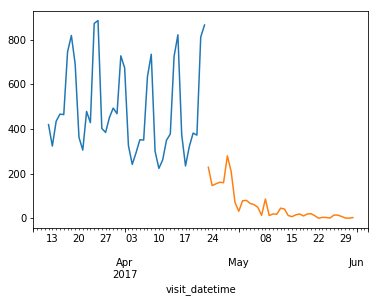

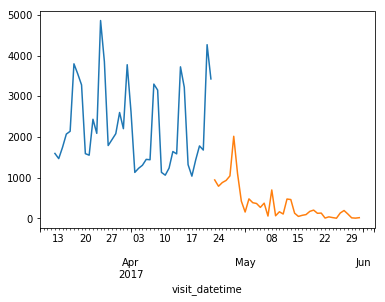

In [28]:
train_rv.groupby('visit_datetime').count()['reserve_visitors'].sort_index().tail(42).plot()
test_rv.groupby('visit_datetime').count()['reserve_visitors'].sort_index().plot()
plt.show()
train_rv.groupby('visit_datetime').sum()['reserve_visitors'].sort_index().tail(42).plot()
test_rv.groupby('visit_datetime').sum()['reserve_visitors'].sort_index().plot()

In [29]:
def f(gap):
    train_rv1=train_rv[train_rv['gap']>=gap]
    test_rv1=test_rv[test_rv['gap']>=gap]    
    train_rv1.groupby('visit_datetime').count()['reserve_visitors'].sort_index().tail(56).plot()
    test_rv1.groupby('visit_datetime').count()['reserve_visitors'].sort_index().plot()
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap),color='g')
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7),color='g')   
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*2),color='g')    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*3),color='g')    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*4),color='g')    

    plt.show()
    train_rv1.groupby('visit_datetime').sum()['reserve_visitors'].sort_index().tail(56).plot()
    test_rv1.groupby('visit_datetime').sum()['reserve_visitors'].sort_index().plot()    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap),color='g')
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7),color='g')    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*2),color='g')    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*3),color='g')    
    plt.axvline(x=pd.to_datetime('2017-4-22')+pd.Timedelta(days=gap-7*4),color='g')    


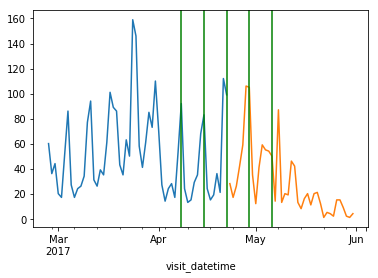

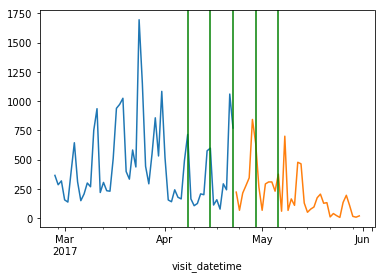

In [30]:
f(14)

In [31]:
#test_rv[test_rv.gap==1].groupby('visit_datetime').count()['reserve_visitors'].sort_index().head(20)

In [32]:
#train_rv[train_rv.gap==1].groupby('visit_datetime').count()['reserve_visitors'].sort_index().tail(28) 

In [33]:
sys.path.insert(0,"../python/rrvf2017/")

In [34]:
import rrvf_data

In [35]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [36]:
rrvf_data.idx_to_date([1])
rrvf_data.idx_to_store([1])

array(['air_0164b9927d20bcc3'],
      dtype='|S20')

In [37]:
reserves['gapXrv']=reserves['gap']*reserves['reserve_visitors']

In [38]:
reserves['store']=reserves['store_id'].map(lambda u: rrvf_data.rev_store_map[u])
reserves['day']=reserves['visit_datetime'].map(lambda u: rrvf_data.rev_date_map[u])

In [39]:
def g(offset):
    subrsv=reserves[reserves.gap>=offset]
    lst=[]
    pvdf=pd.pivot_table(subrsv, columns="day",index='store',values='reserve_visitors',aggfunc='sum')
    pvdf=pvdf.reindex(range(829)).T.reindex(range(517)).T.astype(np.float32)
    lst.append(["rv_sum",pvdf.values])

    pvdf=pd.pivot_table(subrsv, columns="day",index='store',values='reserve_visitors',aggfunc='mean')
    pvdf=pvdf.reindex(range(829)).T.reindex(range(517)).T.astype(np.float32)
    lst.append(["rv_mean",pvdf.values])

    pvdf=pd.pivot_table(subrsv, columns="day",index='store',values='gap',aggfunc='mean')
    pvdf=pvdf.reindex(range(829)).T.reindex(range(517)).T.astype(np.float32)
    lst.append(["rv_gap_mean",pvdf.values])

    pvdf1=pd.pivot_table(subrsv, columns="day",index='store',values='gapXrv',aggfunc='sum')
    pvdf1=pvdf1.reindex(range(829)).T.reindex(range(517)).T.astype(np.float32)
    pvdf2=pd.pivot_table(subrsv, columns="day",index='store',values='reserve_visitors',aggfunc='sum')
    pvdf2=pvdf2.reindex(range(829)).T.reindex(range(517)).T.astype(np.float32)

    pvdf=pvdf1/pvdf2
    lst.append(["rv_gap_weighted_mean",pvdf.values])
    cols=np.array([u[0] for u in lst])
    arr=np.array([u[1] for u in lst])
    print cols.shape,arr.shape,arr.dtype
    return cols,arr

In [40]:
res={}
for offset in range(1,40):
    res[offset]=g(offset)

(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(4,) (4, 829, 517) float32
(

In [44]:
for k in res:
    pickle.dump(res[k],open("../input/reserve_info_offset{}.pkl".format(k),'wb'))

In [42]:
res[1][0]

array(['rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'],
      dtype='|S20')

# ignore

In [161]:
for u in np.arange(0.1,0.8,0.05):
    a=(np.log1p(reserves['y'])-np.log1p(reserves['reserve_visitors'])*u)
    a=a[a<0]
    if len(a)>10:
        print u,np.sqrt(np.mean(a**2))

0.3 0.170726251773
0.35 0.207586976016
0.4 0.262970589425
0.45 0.34167434461
0.5 0.359278028877
0.55 0.425176083014
0.6 0.478359066523
0.65 0.492945118368
0.7 0.524265154176
0.75 0.571661499157


In [126]:
tmpdf=reserves[['store_id','visit_datetime','reserve_visitors','one']].groupby(['store_id','visit_datetime']).sum().reset_index()
tmpdf=pd.merge(tmpdf,train_test,left_on=['store_id','visit_datetime'], right_on=['air_store_id','visit_date'],how='left')
tmpdf['y']=np.expm1(tmpdf['visitors'])

In [127]:
(tmpdf['y']>=tmpdf['reserve_visitors']).mean(),(tmpdf['y']>=tmpdf['reserve_visitors']*.9).mean(),\
(tmpdf['y']>=tmpdf['one']).mean()

(0.89307629801899746, 0.93325674577600937, 0.99518058785620223)

In [130]:
for u in np.arange(0.1,0.8,0.05):
    a=(np.log1p(tmpdf['y'])-np.log1p(tmpdf['reserve_visitors'])*u)
    a=a[a<0]
    print u,np.sqrt(np.mean(a**2))

0.1 nan
0.15 nan
0.2 0.0388060839631
0.25 0.135743423779
0.3 0.229081502094
0.35 0.278290128978
0.4 0.36010177592
0.45 0.413870410674
0.5 0.434772361989
0.55 0.503001464038
0.6 0.540610806283
0.65 0.578030209427
0.7 0.585611583751
0.75 0.611339058177


In [131]:
#if pred < rev count,  set rev count
#if log1p pred < log1p rev sum, set rev sum

In [142]:
test_rv.head()

store_id visit_datetime reserve_datetime  reserve_visitors  \
82204  air_a17f0778617c76e2     2017-05-08       2017-02-03                15   
84684  air_a85f0c0c889f6b7e     2017-05-02       2017-02-08                40   
86169  air_83db5aff8f50478e     2017-05-06       2017-02-11                 5   
87413  air_640cf4835f0d9ba3     2017-04-29       2017-02-14                 2   
87790  air_0a74a5408a0b8642     2017-05-19       2017-02-15                14   

       flag   gap  one  
82204     0  94.0    1  
84684     0  83.0    1  
86169     0  84.0    1  
87413     0  74.0    1  
87790     0  93.0    1

In [164]:
test_rv['th25']=np.expm1(np.log1p(test_rv['reserve_visitors'])*.25)

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [174]:
md=test_rv.groupby(['store_id','visit_datetime']).max()['th25'].reset_index()

In [176]:
test_rv =pd.merge(test_rv,md,on=['store_id','visit_datetime'],how='left')

In [158]:
test_rv['one']=1
test_df = test_rv[['store_id','visit_datetime','one','reserve_visitors']]. \
    groupby(['store_id','visit_datetime' ]).sum() 
test_df.columns=['rev_cnt','rev_sum'] 
test_df['th25']=np.expm1(np.log1p(test_df['rev_sum'])*.25)
test_df['th30']=np.expm1(np.log1p(test_df['rev_sum'])*.30)
test_df=test_df.reset_index()
test_df['min_cnt_th25']=test_df.apply(lambda u: u['rev_cnt'] if u['rev_cnt']>u['th25'] else u['th25'], axis=1)
test_df['min_cnt_th30']=test_df.apply(lambda u: u['rev_cnt'] if u['rev_cnt']>u['th30'] else u['th30'], axis=1)

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [178]:
test_df =pd.merge(test_df,md,on=['store_id','visit_datetime'],how='left')

In [180]:
(test_df['min_cnt_th25']<test_df['th25_y']).mean()

0.0

In [189]:
test_df['id']=test_df[['store_id','visit_datetime']].apply(lambda u: "{}_{}".format(u.values[0],u.values[1].date()),axis=1)

In [191]:
test_df.to_csv("../input/test_min_reverve.csv")

In [57]:
((reserves['y']>1)*(reserves['reserve_visitors']>0)).mean()

0.99881395822909136

In [226]:
b=pd.read_csv("../submission/2001_3001_lgb_lstm_run_0_mean.csv.gz",index_col=0)

In [227]:
test_df.columns

Index([u'store_id', u'visit_datetime', u'rev_cnt', u'rev_sum', u'th25_x',
       u'th30', u'min_cnt_th25', u'min_cnt_th30', u'th25_y', u'id'],
      dtype='object')

In [228]:
b['u']=test_df.set_index("id")['min_cnt_th30']

In [229]:
c=b.dropna()

In [62]:
((reserves['y']>4)*(reserves['reserve_visitors']>0)).mean()

0.98017086414262156

In [31]:
train_rv=reserves[reserves['visit_datetime']<pd.to_datetime('2017-04-23')]
test_rv=reserves[reserves['visit_datetime']>=pd.to_datetime('2017-04-23')]
test_rv.shape

(2201, 6)

In [ ]:
def g(train_rv,gap):
    tmpdf=train_rv['gap']==gap

In [ ]:
pd.concat([train_rv['gap'].value_counts()/train_rv.shape[0],test_rv['gap'].value_counts()/test_rv.shape[0]],axis=1)